## Table of contents:
* [Introduction](#intro)
* [Authorisation step](#authorisation)
* [Download and setting of main funcitons](#settings)
* [Data collections of SentinelHub exploring](#data-collection-exploring)
* [Download data using evalscripts: RGB](#rgb-download)

## Sentinel-2 multispectral data download using SentinelHub <a class="anchor" id="intro"></a>

### General information

> SENTINEL-2 is a European wide-swath, high-resolution, multi-spectral imaging mission. The full mission specification of the twin satellites flying in the same orbit but phased at 180°, is designed to give a high revisit frequency of 5 days at the Equator.
SENTINEL-2 carries an optical instrument payload that samples 13 spectral bands: four bands at 10 m, six bands at 20 m and three bands at 60 m spatial resolution. The orbital swath width is 290 km.

Sentinel-2 is launched in 2014. To date it provides the data of two levels: Level-1 and Level-2: raw and preprocessed data correspondingly. Note, that Level-2 data globally available only since December 2018. For earlier dates user must use [Sen2Cor](https://step.esa.int/main/snap-supported-plugins/sen2cor/) processing tool. 
> The Level-2A processing includes an atmospheric correction applied to Top-Of-Atmosphere (TOA) Level-1C orthoimage products. Level-2A main output is an orthoimage Bottom-Of-Atmosphere (BOA) corrected reflectance product.

This tutorial contains the how-to information about: <br>
1) How to use SentinelHub API? <br>
2) How to download the Sentinel-2 MS data from specific locations and time? <br>
3) How to visualise results? <br>
4) How to save the downloaded data for further work?

For futher work we will need the following list of libraries:
* [rasterio](https://rasterio.readthedocs.io/en/latest/installation.html) – for data to open and analysis <br>
* [gdal / osgeo](https://gdal.org/api/python_bindings.html)  – for data to open and analysis <br>
* [folium](https://python-visualization.github.io/folium/) –  for data dynamic visualisations <br>
* [sentinelhub](https://sentinelhub-py.readthedocs.io/en/latest/examples/process_request.html) – for data downloading <br>


This tutorial is mostly relied on the processing example notebook distributed officially by [**SentinelHub**](https://sentinelhub-py.readthedocs.io/en/latest/examples/process_request.html). To work with it you will need to register on the portal to receive [configuration](https://sentinelhub-py.readthedocs.io/en/latest/configure.html) info.

In [10]:
#download libraries
from sentinelhub import SHConfig
import json #to read json file with credentials
import datetime 
import os

import matplotlib.pyplot as plt 
import numpy as np

## Authorisation step <a class="anchor" id="authorisation"></a>
You will need the following info from you account in SentinelHub: ``client_id``, ``secret_id``, ``instance_id``. In this example I take this data from a separate json file, however it could be done through the editing of configuration file in console, in jupyter notebook directly. 

In [11]:

#read file with credentials
credintails = json.load(open("/Users/polinagogol/Downloads/credintails_Sentinell_SK.json", "r"))

In [12]:
config = SHConfig()

config.sh_client_id = credintails["client_id"]
config.sh_client_secret = credintails["secret_id"]
config.sh_instance_id = credintails["instance_id"]
config.save()

if not config.sh_client_id or not config.sh_client_secret:
    print("Warning! To use Process API, please provide the credentials (OAuth client ID and client secret).")

## Download and setting of main funcitons <a class="anchor" id="settings"></a>

In example notebook on [SentinelHub portal](https://sentinelhub-py.readthedocs.io/en/latest/examples/process_request.html) most of the useful functions are already written. We can modify them if it is needed for authomatisation of the processes or for the code distribution. First we will define sort of functional frame for work.

In [5]:
#importing main functions from sentinelhub library
from sentinelhub import (
    CRS,
    BBox,
    DataCollection,
    DownloadRequest,
    MimeType,
    MosaickingOrder,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    bbox_to_dimensions,
)

#defining plot for visualisation of the downloaded data
def plot_image(image, factor=1.0, clip_range=None, **kwargs):
    """
    Utility function for plotting RGB images.
    """
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))
    if clip_range is not None:
        ax.imshow(np.clip(image * factor, *clip_range), **kwargs)
    else:
        ax.imshow(image * factor, **kwargs)
    ax.set_xticks([])
    ax.set_yticks([])

Then we will set several ``evalscripts``: for all bands ``evalscript_all_bands`` and for true color (Red+Green+Blue) ``evalscript_true_color`` separately

In [6]:
#true color
evalscript_true_color = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04"]
            }],
            output: {
                bands: 3
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B04, sample.B03, sample.B02];
    }
"""

In [7]:
#all bands
evalscript_all_bands = """
    //VERSION=3
    function setup() {
        return {
            input: [{
                bands: ["B01","B02","B03","B04","B05","B06","B07","B08","B8A","B09","B10","B11","B12"],
                units: "DN"
            }],
            output: {
                bands: 13,
                sampleType: "INT16"
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B01,
                sample.B02,
                sample.B03,
                sample.B04,
                sample.B05,
                sample.B06,
                sample.B07,
                sample.B08,
                sample.B8A,
                sample.B09,
                sample.B10,
                sample.B11,
                sample.B12];
    }
"""

## Data collections <a class="anchor" id="data-collection-exploring"></a>

We can explore both available collections of the remote sensing data and information about each collection

In [8]:
#explore supported collections
print("Supported DataCollections:\n")
for collection in DataCollection.get_available_collections():
    print(collection)

Supported DataCollections:

DataCollection.SENTINEL2_L1C
DataCollection.SENTINEL2_L2A
DataCollection.SENTINEL1
DataCollection.SENTINEL1_IW
DataCollection.SENTINEL1_IW_ASC
DataCollection.SENTINEL1_IW_DES
DataCollection.SENTINEL1_EW
DataCollection.SENTINEL1_EW_ASC
DataCollection.SENTINEL1_EW_DES
DataCollection.SENTINEL1_EW_SH
DataCollection.SENTINEL1_EW_SH_ASC
DataCollection.SENTINEL1_EW_SH_DES
DataCollection.DEM
DataCollection.DEM_MAPZEN
DataCollection.DEM_COPERNICUS_30
DataCollection.DEM_COPERNICUS_90
DataCollection.MODIS
DataCollection.LANDSAT_MSS_L1
DataCollection.LANDSAT_TM_L1
DataCollection.LANDSAT_TM_L2
DataCollection.LANDSAT_ETM_L1
DataCollection.LANDSAT_ETM_L2
DataCollection.LANDSAT_OT_L1
DataCollection.LANDSAT_OT_L2
DataCollection.SENTINEL5P
DataCollection.SENTINEL3_OLCI
DataCollection.SENTINEL3_SLSTR


In [116]:
#receive catalog
from sentinelhub import SentinelHubCatalog
catalog = SentinelHubCatalog(config=config)
catalog.get_info()

{'type': 'Catalog',
 'stac_version': '1.0.0',
 'id': 'sentinel-hub',
 'title': 'Sentinel Hub STAC catalog',
 'description': 'STAC v1.0.0 implementation by Sentinel Hub',
 'conformsTo': ['http://www.opengis.net/spec/ogcapi-features-1/1.0/conf/core',
  'http://www.opengis.net/spec/ogcapi-features-1/1.0/conf/oas30',
  'http://www.opengis.net/spec/ogcapi-features-1/1.0/conf/geojson',
  'https://api.stacspec.org/v1.0.0-rc.2/core',
  'https://api.stacspec.org/v1.0.0-rc.2/collections',
  'https://api.stacspec.org/v1.0.0-rc.2/ogcapi-features',
  'https://api.stacspec.org/v1.0.0-rc.2/ogcapi-features#fields',
  'https://api.stacspec.org/v1.0.0-rc.2/ogcapi-features#context',
  'https://api.stacspec.org/v1.0.0-rc.2/ogcapi-features#filter',
  'https://api.stacspec.org/v1.0.0-rc.2/item-search',
  'https://api.stacspec.org/v1.0.0-rc.2/item-search#fields',
  'https://api.stacspec.org/v1.0.0-rc.2/item-search#context',
  'https://api.stacspec.org/v1.0.0-rc.2/item-search#filter',
  'http://www.opengis.ne

Let's have a look to the data of Level 2 of Sentinel-2 collections: we can see it contants coverage, interval for available data, bands descriptions.

In [119]:
catalog.get_collection(DataCollection.SENTINEL2_L2A)

{'stac_version': '1.0.0',
 'stac_extensions': ['https://stac-extensions.github.io/eo/v1.0.0/schema.json'],
 'type': 'Collection',
 'id': 'sentinel-2-l2a',
 'title': 'Sentinel 2 L2A',
 'description': 'Sentinel 2 imagery processed to level 2A',
 'license': 'proprietary',
 'providers': [{'name': 'ESA',
   'roles': ['producer'],
   'url': 'https://esa.int/'},
  {'name': 'AWS', 'roles': ['host'], 'url': 'https://aws.amazon.com/'},
  {'name': 'Sinergise',
   'roles': ['processor'],
   'url': 'https://www.sinergise.com/'}],
 'extent': {'spatial': {'bbox': [[-180.0, -56.0, 180.0, 83.0]]},
  'temporal': {'interval': [['2016-11-01T00:00:00Z', None]]}},
 'summaries': {'eo:bands': [{'name': 'B01',
    'common_name': 'coastal',
    'center_wavelength': 0.4427,
    'full_width_half_max': 0.021},
   {'name': 'B02',
    'common_name': 'blue',
    'center_wavelength': 0.4924,
    'full_width_half_max': 0.066},
   {'name': 'B03',
    'common_name': 'green',
    'center_wavelength': 0.5598,
    'full_wid

## Download data using evalscripts: RGB <a class="anchor" id="rgb-download"></a>

The original example notebook contained processing of the Betsiboka Estuary. We use here another quite beautifil lokation of Palma di Mallorka.

In [46]:
#longitude and latitude coordinates of lower left and upper right corners
palma_di_majorka_wgs84 = [2.57,39.51, 2.78, 39.69]

In [68]:
resolution = 20
palma_di_majorka_bbox = BBox(bbox=palma_di_majorka_wgs84, crs=CRS.WGS84)
palma_di_majorka_size = bbox_to_dimensions(palma_di_majorka_bbox, resolution=resolution)

print(f"Image shape at {resolution} m resolution: {palma_di_majorka_size} pixels")

Image shape at 20 m resolution: (905, 996) pixels


In [97]:
#function for data request
request_true_color = SentinelHubRequest(
    evalscript=evalscript_true_color, #script
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A, #collection
            time_interval=("2020-06-12", "2020-06-24"), #time period
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    bbox=betsiboka_bbox,
    size=betsiboka_size,
    config=config,
)

In [98]:
true_color_imgs = request_true_color.get_data()

In [101]:
print(f"Returned data is of type = {type(true_color_imgs)} and length {len(true_color_imgs)}.")
print(f"Single element in the list is of type {type(true_color_imgs[-1])} and has shape {true_color_imgs[-1].shape}")

Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (996, 905, 3)


Image type: uint8


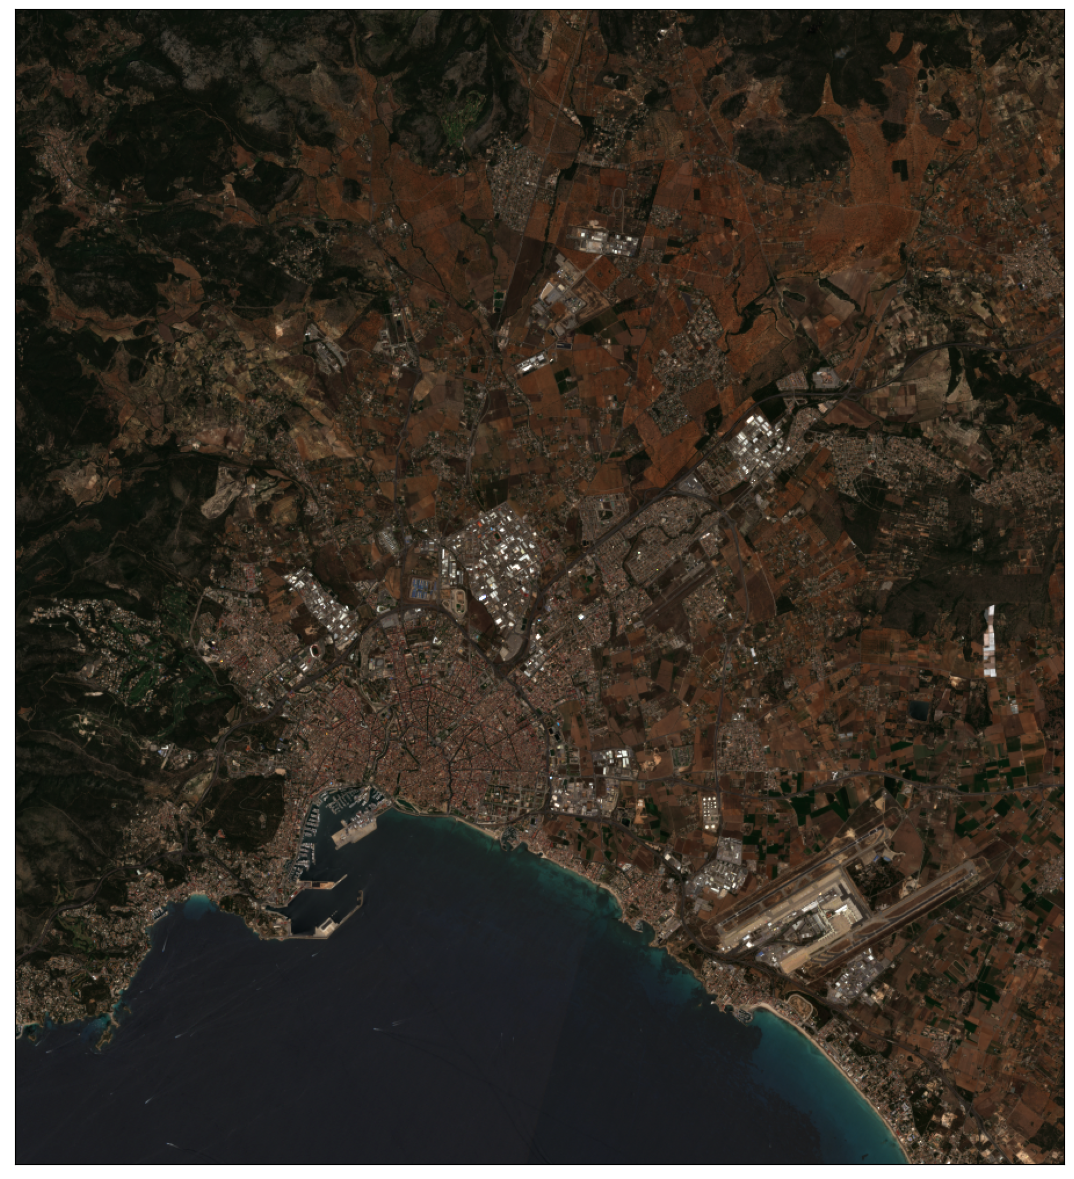

In [102]:
image = true_color_imgs[0]
print(f"Image type: {image.dtype}")

# plot function
# factor 1/255 to scale between 0-1
# factor 3.5 to increase brightness
plot_image(image, factor=1.5 / 255, clip_range=(0, 1))

In [103]:
DataCollection

<enum 'DataCollection'>

In [122]:
request_all_bands = SentinelHubRequest(
    data_folder="test_dir",
    evalscript=evalscript_all_bands,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C,
            time_interval=("2020-06-01", "2020-06-30"),
            mosaicking_order=MosaickingOrder.LEAST_CC,
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
    bbox=palma_di_majorka_bbox,
    size=palma_di_majorka_size,
    config=config,
)

In [123]:
all_bands_img = request_all_bands.get_data(save_data=True)

In [124]:
print(
    "The output directory has been created and a tiff file with all 13 bands was saved into the following structure:\n"
)

for folder, _, filenames in os.walk(request_all_bands.data_folder):
    for filename in filenames:
        print(os.path.join(folder, filename))

The output directory has been created and a tiff file with all 13 bands was saved into the following structure:

test_dir/ea95efd1a27203c997eda52d13252fa4/request.json
test_dir/ea95efd1a27203c997eda52d13252fa4/response.tiff
